# Dataset

Download the dataset and save it to a directory at per your convience. [IMDB comments](https://github.com/abulbasar/data/blob/master/imdb-comments.json.zip?raw=true)

In [1]:
import pandas as pd # Used for dataframe functions
import json # parse json string
import nltk # Natural language toolkit for TDIDF etc.
from bs4 import BeautifulSoup # Parse html string .. to extract text
import re # Regex parser 
import numpy as np # Linear algebbra 
from sklearn import * # machine learning
import matplotlib.pyplot as plt # Visualization


# Wordcloud does not work on Windows. 
# Comment the below if you want to skip
from wordcloud import WordCloud # Word cloud visualization
import scipy #Sparse matrix 

np.set_printoptions(precision=4)
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 10
pd.options.display.float_format = lambda f: "%.4f" % f

%matplotlib inline 

Run the following line when you run this notebook first time.

In [2]:
# nltk.download("punkt")
# nltk.download("stopwords")
# nltk.download("wordnet")
# nltk.download('averaged_perceptron_tagger')

In [3]:
print(nltk.__version__)

3.4.1


In [4]:
sentence = """European authorities fined Google a record $5.1 billion on Wednesday for 
abusing its power in the mobile phone market and ordered the company to alter its practices"""

In [5]:
nltk.word_tokenize(sentence)

['European',
 'authorities',
 'fined',
 'Google',
 'a',
 'record',
 '$',
 '5.1',
 'billion',
 'on',
 'Wednesday',
 'for',
 'abusing',
 'its',
 'power',
 'in',
 'the',
 'mobile',
 'phone',
 'market',
 'and',
 'ordered',
 'the',
 'company',
 'to',
 'alter',
 'its',
 'practices']

In [6]:
nltk.pos_tag(nltk.word_tokenize(sentence))

[('European', 'JJ'),
 ('authorities', 'NNS'),
 ('fined', 'VBD'),
 ('Google', 'NNP'),
 ('a', 'DT'),
 ('record', 'NN'),
 ('$', '$'),
 ('5.1', 'CD'),
 ('billion', 'CD'),
 ('on', 'IN'),
 ('Wednesday', 'NNP'),
 ('for', 'IN'),
 ('abusing', 'VBG'),
 ('its', 'PRP$'),
 ('power', 'NN'),
 ('in', 'IN'),
 ('the', 'DT'),
 ('mobile', 'JJ'),
 ('phone', 'NN'),
 ('market', 'NN'),
 ('and', 'CC'),
 ('ordered', 'VBD'),
 ('the', 'DT'),
 ('company', 'NN'),
 ('to', 'TO'),
 ('alter', 'VB'),
 ('its', 'PRP$'),
 ('practices', 'NNS')]

### POS Tag description
```
CC coordinating conjunction
CD cardinal digit
DT determiner (the)
EX existential there (like: “there is” … think of it like “there exists”)
FW foreign word
IN preposition/subordinating conjunction
JJ adjective ‘big’
JJR adjective, comparative ‘bigger’
JJS adjective, superlative ‘biggest’
LS list marker 1)
MD modal could, will
NN noun, singular ‘desk’
NNS noun plural ‘desks’
NNP proper noun, singular ‘Harrison’
NNPS proper noun, plural ‘Americans’
PDT predeterminer ‘all the kids’
POS possessive ending parent’s
PRP personal pronoun I, he, she
PRP$ possessive pronoun my, his, hers
RB adverb very, silently,
RBR adverb, comparative better
RBS adverb, superlative best
RP particle give up
TO, to go ‘to’ the store.
UH interjection, errrrrrrrm
VB verb, base form take
VBD verb, past tense took
VBG verb, gerund/present participle taking
VBN verb, past participle taken
VBP verb, sing. present, non-3d take
VBZ verb, 3rd person sing. present takes
WDT wh-determiner which
WP wh-pronoun who, what
WP$ possessive wh-pronoun whose
WRB wh-abverb where, when
```

# Spacy

spaCy is an open-source software library for advanced Natural Language Processing, written in the programming languages Python and Cython. It is slightly more ready enterprise use cases. Its out of box POS tagger, NER analyzers are very popular. 



In [7]:
"""
Install spacy
$ pip install spacy

Download en_core_web_sm module
$ python -m spacy download en_core_web_sm

"""

import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

doc = nlp(sentence)
[(X.text, X.label_) for X in doc.ents]

[('European', 'NORP'),
 ('Google', 'ORG'),
 ('$5.1 billion', 'MONEY'),
 ('Wednesday', 'DATE')]

Display dependency graph

In [8]:
displacy.render(nlp(str(sentence)), style='dep', jupyter = True, options = {'distance': 120})

In [9]:
[(x.orth_,x.pos_, x.lemma_) 
     for x in [y for y in nlp(sentence) 
               if not y.is_stop and y.pos_ != 'PUNCT']]

[('European', 'ADJ', 'european'),
 ('authorities', 'NOUN', 'authority'),
 ('fined', 'VERB', 'fine'),
 ('Google', 'PROPN', 'Google'),
 ('record', 'NOUN', 'record'),
 ('$', 'SYM', '$'),
 ('5.1', 'NUM', '5.1'),
 ('billion', 'NUM', 'billion'),
 ('Wednesday', 'PROPN', 'Wednesday'),
 ('\n', 'SPACE', '\n'),
 ('abusing', 'VERB', 'abuse'),
 ('power', 'NOUN', 'power'),
 ('mobile', 'ADJ', 'mobile'),
 ('phone', 'NOUN', 'phone'),
 ('market', 'NOUN', 'market'),
 ('ordered', 'VERB', 'order'),
 ('company', 'NOUN', 'company'),
 ('alter', 'VERB', 'alter'),
 ('practices', 'NOUN', 'practice')]

Now let's see how to create text classifier using nltk and scikit learn.

In [10]:
# The following line does not work on Windows system
!head -n 1 /data/imdb-comments.json

{"label":"test","sentiment":"pos","name":"0_10.txt","content":"I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge."}


In [11]:
data = []
with open("/data/imdb-comments.json", "r", encoding="utf8") as f:
    for l in f.readlines():
        data.append(json.loads(l))    

In [12]:
comments = pd.DataFrame.from_dict(data)
comments.sample(10)

,content,label,name,sentiment
9743,Low-budget but memorable would-be shocker that...,test,751_7.txt,pos
5946,The retelling of a classic story is set to the...,test,4101_8.txt,pos
21604,This was one of the worst movies I've ever see...,test,6945_1.txt,neg
9261,"I don't cry easily over movies, but I have to ...",test,7086_8.txt,pos
32,"I first viewed ""They Died With There Boots On""...",test,10029_10.txt,pos
9274,Despite all of the comparisons to House of Fra...,test,7098_10.txt,pos
29287,I'm writing this 9 years after the final episo...,train,2609_10.txt,pos
41158,Zodiac Killer. 1 out of 10. Worst acting ever....,train,2042_1.txt,neg
5979,Gary Busey is superb in this musical biography...,test,4131_9.txt,pos
39805,This Hamlet made for one of the boringest MST3...,train,12075_1.txt,neg


In [13]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
content      50000 non-null object
label        50000 non-null object
name         50000 non-null object
sentiment    50000 non-null object
dtypes: object(4)
memory usage: 1.5+ MB


In [14]:
comments.label.value_counts()

train    25000
test     25000
Name: label, dtype: int64

In [15]:
comments.groupby(["label", "sentiment"]).content.count().unstack()

sentiment,neg,pos
label,,
test,12500,12500
train,12500,12500


In [16]:
np.random.seed(1)
v = list(comments["content"].sample(1))[0]
v

'When we started watching this series on cable, I had no idea how addictive it would be. Even when you hate a character, you hold back because they are so beautifully developed, you can almost understand why they react to frustration, fear, greed or temptation the way they do. It\'s almost as if the viewer is experiencing one of Christopher\'s learning curves.<br /><br />I can\'t understand why Adriana would put up with Christopher\'s abuse of her, verbally, physically and emotionally, but I just have to read the newspaper to see how many women can and do tolerate such behavior. Carmella has a dream house, endless supply of expensive things, but I\'m sure she would give it up for a loving and faithful husband - or maybe not. That\'s why I watch.<br /><br />It doesn\'t matter how many times you watch an episode, you can find something you missed the first five times. We even watch episodes out of sequence (watch season 1 on late night with commercials but all the language, A&E with lang

In [17]:
def preprocess(text):
    
    # Remove html tags
    text = BeautifulSoup(text.lower(), "html5lib").text 
    
    # Replace the occurrences of multiple consecutive non-word ccharacters 
    # with a single space (" ")
    text = re.sub(r"[\W]+", " ", text)
    return text

preprocess(v)

'when we started watching this series on cable i had no idea how addictive it would be even when you hate a character you hold back because they are so beautifully developed you can almost understand why they react to frustration fear greed or temptation the way they do it s almost as if the viewer is experiencing one of christopher s learning curves i can t understand why adriana would put up with christopher s abuse of her verbally physically and emotionally but i just have to read the newspaper to see how many women can and do tolerate such behavior carmella has a dream house endless supply of expensive things but i m sure she would give it up for a loving and faithful husband or maybe not that s why i watch it doesn t matter how many times you watch an episode you can find something you missed the first five times we even watch episodes out of sequence watch season 1 on late night with commercials but all the language a e with language censored reruns on the movie network whenever 

In [18]:
%%time
# Apply the preprocessing logic to all comments
comments["content"] = comments["content"].apply(preprocess)

CPU times: user 31.6 s, sys: 97 ms, total: 31.7 s
Wall time: 31.7 s


In [19]:
comments_train = comments[comments["label"] == "train"]
comments_train.sample(10)

,content,label,name,sentiment
25496,there are many people in our lives that we mee...,train,10447_10.txt,pos
41520,sixth escapade for freddy krueger in which he ...,train,2369_4.txt,neg
48525,the first few minutes of the bodyguard do have...,train,8674_2.txt,neg
26037,after reviewing this intense martial arts movi...,train,10934_10.txt,pos
43823,triumph of love is proof that not every coméd...,train,4441_3.txt,neg
39666,this is without a doubt the worst movie i have...,train,11950_2.txt,neg
40882,i had the opportunity to preview this film as ...,train,1795_2.txt,neg
43156,roeg has done some great movies but this a tur...,train,3841_1.txt,neg
37185,possible spoiler in some way how to alienate f...,train,9718_7.txt,pos
40330,sogo ishii can be a skilled filmmaker under th...,train,1298_3.txt,neg


In [20]:
comments_test = comments[comments["label"] == "test"]
comments_test.sample(10)

,content,label,name,sentiment
21277,this is one of those movies where i was rootin...,test,6650_1.txt,neg
12620,spoilersi m going to be as kind as i can about...,test,10108_1.txt,neg
4485,as a former erasmus student i enjoyed this fil...,test,2788_9.txt,pos
4744,francis ford coppola s masterpiece was a great...,test,301_10.txt,pos
10329,some of the reviewers here have foolishly judg...,test,8047_10.txt,pos
14366,this is by far one of the most pretentious fil...,test,11680_1.txt,neg
1007,this is truly a funny movie his dance scene do...,test,10907_8.txt,pos
4539,this film released in 1951 has the usual eleme...,test,2836_8.txt,pos
7864,one of the best tv shows out there if not the ...,test,5829_10.txt,pos
19582,this movie was jerry bruckheimer s idea to sel...,test,5124_4.txt,neg


In [21]:
X_train = comments_train["content"].values
y_train = np.where(comments_train.sentiment == "pos", 1, 0)

In [22]:
X_test = comments_test["content"].values
y_test = np.where(comments_test.sentiment == "pos", 1, 0)

In [23]:
# http://snowball.tartarus.org/algorithms/porter/stemmer.html
# http://www.nltk.org/howto/stem.html

from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
print(SnowballStemmer.languages)

('arabic', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'hungarian', 'italian', 'norwegian', 'porter', 'portuguese', 'romanian', 'russian', 'spanish', 'swedish')


In [24]:
porter = PorterStemmer()
snowball = SnowballStemmer("english")
lemmatizer = nltk.wordnet.WordNetLemmatizer()

values = []

for s in nltk.word_tokenize("""
            revival
            allowance 
            inference 
            relational
            runner
            runs
            ran
            has
            having
            generously
            wasn't
            leaves
            swimming
            relative
            relating
            """):
    values.append((s, porter.stem(s)
          , snowball.stem(s), lemmatizer.lemmatize(s, "v")))
    
pd.DataFrame(values, columns = ["original", "porter", "snowball", "lemmatizer"])

,original,porter,snowball,lemmatizer
0,revival,reviv,reviv,revival
1,allowance,allow,allow,allowance
2,inference,infer,infer,inference
3,relational,relat,relat,relational
4,runner,runner,runner,runner
...,...,...,...,...
10,wasn't,wasn't,wasn't,wasn't
11,leaves,leav,leav,leave
12,swimming,swim,swim,swim
13,relative,rel,relat,relative


In [25]:
stopwords = nltk.corpus.stopwords.words("english")
print(len(stopwords), stopwords)

179 ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than

Lets drop the following words from stopwords since they are likely good indicator of sentiment.

In [26]:
stopwords.remove("no")
stopwords.remove("nor")
stopwords.remove("not")

In [27]:
#stemmer = SnowballStemmer("english")
stemmer = PorterStemmer()
def my_tokenizer(s):
    #terms = nltk.word_tokenize(s.lower())
    terms = re.split("\s", s.lower())
    terms = [re.sub(r"[\.!]", "", v) for v in terms if len(v)>2]
    terms = [v for v in terms if len(v)>2]
    terms = [v for v in terms if v not in stopwords]
    terms = [stemmer.stem(w) for w in terms]
    terms = [term for term in terms if len(term) > 2]
    return terms 
my_tokenizer(sentence)

['european',
 'author',
 'fine',
 'googl',
 'record',
 '$51',
 'billion',
 'wednesday',
 'abus',
 'power',
 'mobil',
 'phone',
 'market',
 'order',
 'compani',
 'alter',
 'practic']

In [28]:
tfidf = feature_extraction.text.TfidfVectorizer(tokenizer=my_tokenizer
                                                , ngram_range=(1, 2))

corpus = ["Today is Wednesday"
          , "Delhi weather is hot today."
          , "Delhi roads are not busy in the morning"]

doc_term_matrix = tfidf.fit_transform(corpus)

# returns term and index in the feature matrix
print("Vocabulary: ", tfidf.vocabulary_) 

Vocabulary:  {'today': 12, 'wednesday': 16, 'today wednesday': 13, 'delhi': 2, 'weather': 14, 'hot': 5, 'delhi weather': 4, 'weather hot': 15, 'hot today': 6, 'road': 10, 'not': 8, 'busi': 0, 'morn': 7, 'delhi road': 3, 'road not': 11, 'not busi': 9, 'busi morn': 1}


In [29]:
columns = [None] * len(tfidf.vocabulary_)
for term in tfidf.vocabulary_:
    columns[tfidf.vocabulary_[term]] = term
columns
scores = pd.DataFrame(doc_term_matrix.toarray()
                      , columns= columns)
scores

,busi,busi morn,delhi,delhi road,delhi weather,hot,hot today,morn,not,not busi,road,road not,today,today wednesday,weather,weather hot,wednesday
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.4736,0.6228,0.0000,0.0000,0.6228
1,0.0000,0.0000,0.3065,0.0000,0.4030,0.4030,0.4030,0.0000,0.0000,0.0000,0.0000,0.0000,0.3065,0.0000,0.4030,0.4030,0.0000
2,0.3414,0.3414,0.2597,0.3414,0.0000,0.0000,0.0000,0.3414,0.3414,0.3414,0.3414,0.3414,0.0000,0.0000,0.0000,0.0000,0.0000


In [30]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [31]:
X_test_tfidf.shape, y_test.shape, X_train_tfidf.shape, y_train.shape

((25000, 1563344), (25000,), (25000, 1563344), (25000,))

Let's estimate the memory requirment if the data is presented in dense matrix format

In [32]:
cell_count = np.product(X_train_tfidf.shape)
bytes = cell_count * 4 
GBs = bytes / (1024 ** 3) 
GBs

145.59775590896606

In [33]:
sparsity = 1 - X_train_tfidf.count_nonzero() / cell_count
sparsity

0.9998659233796272

In [34]:
1 - X_train_tfidf.nnz / cell_count

0.9998659233796272

In [35]:
print("Type of doc_term_matrix", type(X_train_tfidf))

Type of doc_term_matrix <class 'scipy.sparse.csr.csr_matrix'>


Byte size of the training doc sparse doc

In [36]:
print(X_train_tfidf.data.nbytes / (1024.0 ** 3), "GB")

0.03904251009225845 GB


# Classification Model

In [37]:
%%time
lr = linear_model.LogisticRegression(C = 0.6, random_state = 1
                            , n_jobs = 8, solver="saga")
lr.fit(X_train_tfidf, y_train)
y_train_pred = lr.predict(X_train_tfidf)
y_test_pred = lr.predict(X_test_tfidf)
print("Training accuracy: ", metrics.accuracy_score(y_train, y_train_pred))
print("Test accuracy: ", metrics.accuracy_score(y_test, y_test_pred))

Training accuracy:  0.9394
Test accuracy:  0.874
CPU times: user 4.81 s, sys: 15.6 ms, total: 4.82 s
Wall time: 4.05 s


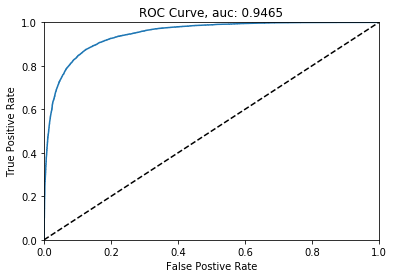

In [38]:
fpr, tpr, thresholds = metrics.roc_curve(y_test,
                        lr.predict_proba(X_test_tfidf)[:, [1]])
auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr)
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.plot([0,1], [0,1], ls = "--", color = "k")
plt.xlabel("False Postive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve, auc: %.4f" % auc);

In [39]:
%%time
from sklearn import naive_bayes, ensemble
bayes = naive_bayes.MultinomialNB(alpha=1)
bayes.fit(X_train_tfidf, y_train)
print("accuracy: ", bayes.score(X_test_tfidf, y_test))

accuracy:  0.86116
CPU times: user 481 ms, sys: 81.9 ms, total: 563 ms
Wall time: 182 ms


In [40]:
%%time
est = tree.DecisionTreeClassifier()
est.fit(X_train_tfidf, y_train)
print("accuracy: ", est.score(X_test_tfidf, y_test))

accuracy:  0.70016
CPU times: user 2min 54s, sys: 207 ms, total: 2min 54s
Wall time: 2min 52s


In [41]:
columns = [None] * len(tfidf.vocabulary_)
for term in tfidf.vocabulary_:
    columns[tfidf.vocabulary_[term]] = term
result = pd.DataFrame({"feature": columns
                    , "importance": est.feature_importances_})
result = result.sort_values("importance", ascending = False)
result = result[result.importance > 0.0]
print("Top 50 terms: ", list(result.feature[:50]))

Top 50 terms:  ['bad', 'worst', 'wast', 'great', 'bore', 'terribl', 'love', 'noth', 'stupid', 'excel', 'poor', 'best', 'enjoy', 'movi', 'disappoint', 'beauti', 'wors', 'poorli', 'perfect', 'not', 'fail', 'dull', 'film', 'see', 'like', 'pointless', 'tri', 'also', 'one', 'minut', 'unfortun', 'well', 'ridicul', 'one best', 'suppos', 'look', 'perform', 'act', 'instead', 'good', 'mess', 'anyth', 'lame', 'money', 'better', 'save', 'dream', 'still', 'seem', 'world']


# Important terms for a document 

In [42]:
vocab_by_term = tfidf.vocabulary_
vocab_by_idx = dict({(vocab_by_term[term], term) 
                                 for term in vocab_by_term})

In [43]:
str(vocab_by_term)[:100]

"{'bromwel': 179261, 'high': 641518, 'cartoon': 208227, 'comedi': 265770, 'ran': 1100494, 'time': 140"

In [44]:
str(vocab_by_idx)[:100]

"{296951: 'correspond well', 658061: 'horror frankli', 262774: 'com ident', 1534619: 'wonder shanghai"

In [45]:
idx = 5
print("Content:\n", X_train[idx])
row = X_train_tfidf[idx]
terms = [(vocab_by_idx[row.indices[i]], row.data[i])
             for i, term in enumerate(row.indices)]
pd.Series(dict(terms)).sort_values(ascending = False)

Content:
 this isn t the comedic robin williams nor is it the quirky insane robin williams of recent thriller fame this is a hybrid of the classic drama without over dramatization mixed with robin s new love of the thriller but this isn t a thriller per se this is more a mystery suspense vehicle through which williams attempts to locate a sick boy and his keeper also starring sandra oh and rory culkin this suspense drama plays pretty much like a news report until william s character gets close to achieving his goal i must say that i was highly entertained though this movie fails to teach guide inspect or amuse it felt more like i was watching a guy williams as he was actually performing the actions from a third person perspective in other words it felt real and i was able to subscribe to the premise of the story all in all it s worth a watch though it s definitely not friday saturday night fare it rates a 7 7 10 from the fiend 


william         0.2206
robin           0.1737
robin william   0.1333
thriller        0.1286
boy keeper      0.1013
                 ...  
stori           0.0208
charact         0.0204
get             0.0196
not             0.0147
movi            0.0139
Length: 166, dtype: float64

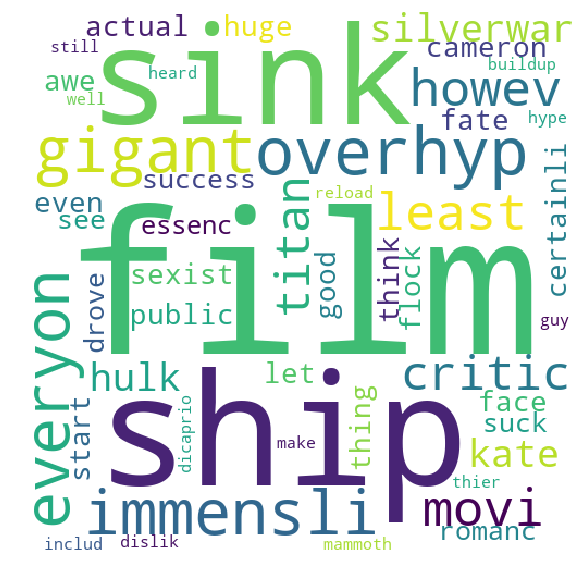

In [46]:
idx = 50
row = X_train_tfidf[idx]
terms = [(vocab_by_idx[row.indices[i]], row.data[i]) 
                 for i, term in enumerate(row.indices)]
top_terms= list(pd.Series(dict(terms))\
                .sort_values(ascending = False)[:50].index)
wc = WordCloud(background_color="white", 
    width=500, height=500, max_words=50).generate("+".join(top_terms))
plt.figure(figsize=(10, 10))
plt.imshow(wc)
plt.axis("off");

# Build Pipeline for classificaiton Model

In [47]:
%%time
tfidf =feature_extraction.text.TfidfVectorizer(
              tokenizer=my_tokenizer
            , stop_words = stopwords
            , ngram_range=(1, 2)
        )

pipe = pipeline.Pipeline([
    ("tfidf", tfidf),
    ("est", linear_model.LogisticRegression(C = 1.0, random_state = 1
                            , n_jobs = 8, solver="saga"))
])
pipe.fit(X_train, y_train)

CPU times: user 1min 20s, sys: 381 ms, total: 1min 20s
Wall time: 1min 17s


In [48]:
import pickle

In [49]:
with open("/tmp/model.pkl", "wb") as f:
    pickle.dump(pipe, f)

In [50]:
!ls -lh /tmp/model.pkl

-rw-r--r--  1 abasar  wheel   123M May 30 10:14 /tmp/model.pkl


In [51]:
with open("/tmp/model.pkl", "rb") as f:
    model = pickle.load(f)

In [52]:
doc1 = """when we started watching this series on 
cable i had no idea how addictive it would be 
even when you hate a character you hold back because 
they are so beautifully developed you can almost
understand why they react to frustration fear greed 
or temptation the way they do it s almost as if the
viewer is experiencing one of christopher s learning 
curves i can t understand why adriana would put up with 
christopher s abuse of her verbally physically and 
emotionally but i just have to read the newspaper to 
see how many women can and do tolerate such behavior 
carmella has a dream house endless supply of expensive 
things but i m sure she would give it up for a loving 
and faithful husband or maybe not that s why i watch 
it doesn t matter how many times you watch an episode
you can find something you missed the first five times 
we even watch episodes out of sequence watch season 1 
on late night with commercials but all the language a e 
with language censored reruns on the movie network whenever 
they re on we re there we ve been totally spoiled now i also 
love the malaprop s an albacore around my neck is my favorite of
johnny boy when these jewels have entered our family vocabulary 
it is a sign that i should get a life i will when the series
ends and i have collected all the dvd s and put the collection 
in my will"""
doc1 = preprocess(doc1)

In [53]:
model.predict_proba(np.array([doc1]))[:, 1]

array([0.8004])

# Hashing Vectorizer



Convert a collection of text documents to a matrix of deterministic hash token (murmur3) occurrences

It turns a collection of text documents into a scipy.sparse matrix holding token occurrence counts (or binary occurrence information), possibly normalized as token frequencies if norm=’l1’ or projected on the euclidean unit sphere if norm=’l2’.

Advantages 
- it is very low memory scalable to large datasets as there is no need to store a vocabulary dictionary in memory
- it is fast to pickle and un-pickle as it holds no state besides the constructor parameters
- it can be used in a streaming (partial fit) or parallel pipeline as there is no state computed during fit.

Disadvantages
- there is no way to compute the inverse transform (from feature indices to string feature names) which can be a problem when trying to introspect which features are most important to a model.
- there can be collisions: distinct tokens can be mapped to the same feature index. However in practice this is rarely an issue if n_features is large enough (e.g. 2 ** 18 for text classification problems).
- no IDF weighting as this would render the transformer stateful.

In [54]:
hashing_vectorizer = feature_extraction.text.HashingVectorizer(n_features=2 ** 3
                                            , tokenizer=my_tokenizer, ngram_range=(1, 2))

corpus = ["Today is Wednesday"
          , "Delhi weather is hot today."
          , "Delhi roads are not busy in the morning"]

doc_term_matrix = hashing_vectorizer.fit_transform(corpus)

pd.DataFrame(doc_term_matrix.toarray()) # Each cell is normalized (l2) row-wise


,0,1,2,3,4,5,6,7
0,0.0000,0.5774,0.0000,0.5774,0.0000,0.0000,-0.5774,0.0000
1,0.0000,0.3780,0.7559,0.0000,0.0000,-0.3780,-0.3780,0.0000
2,0.0000,-0.4472,0.0000,0.0000,0.4472,-0.4472,-0.4472,0.4472


In [55]:
%%time

n_features = 2 ** 20

hashing_vectorizer = feature_extraction.text.HashingVectorizer(n_features=n_features
                                         , tokenizer=my_tokenizer, ngram_range=(1, 2))
X_train_hash = hashing_vectorizer.fit_transform(X_train)
X_test_hash = hashing_vectorizer.transform(X_test)

CPU times: user 2min 14s, sys: 304 ms, total: 2min 14s
Wall time: 2min 6s


In [56]:
X_train_hash

<25000x1048576 sparse matrix of type '<class 'numpy.float64'>'
	with 5239460 stored elements in Compressed Sparse Row format>

In [57]:
X_train_hash.shape, X_test_hash.shape

((25000, 1048576), (25000, 1048576))

In [58]:
print(X_train_hash.data.nbytes / (1024.0 ** 3), "GB")

0.03903701901435852 GB


In [59]:
%%time
lr = linear_model.LogisticRegression(C = 1.0, random_state = 1,
                            solver = "liblinear")
lr.fit(X_train_hash, y_train)
y_train_pred = lr.predict(X_train_hash)
y_test_pred = lr.predict(X_test_hash)
print("Training accuracy: ", metrics.accuracy_score(y_train, y_train_pred))
print("Test accuracy: ", metrics.accuracy_score(y_test, y_test_pred))

Training accuracy:  0.91888
Test accuracy:  0.87364
CPU times: user 17 s, sys: 157 ms, total: 17.1 s
Wall time: 2.96 s
